In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

       4329.23  4009.23  4289.23  4148.21  4350.26  4586.15  4096.92  4641.03  \
0      4324.62  4004.62  4293.85  4148.72  4342.05  4586.67  4097.44  4638.97   
1      4327.69  4006.67  4295.38  4156.41  4336.92  4583.59  4096.92  4630.26   
2      4328.72  4011.79  4296.41  4155.90  4343.59  4582.56  4097.44  4630.77   
3      4326.15  4011.79  4292.31  4151.28  4347.69  4586.67  4095.90  4627.69   
4      4321.03  4004.62  4284.10  4153.33  4345.64  4587.18  4093.33  4616.92   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14974  4281.03  3990.26  4245.64  4116.92  4333.85  4614.36  4074.87  4625.64   
14975  4276.92  3991.79  4245.13  4110.77  4332.82  4615.38  4073.33  4621.54   
14976  4277.44  3990.77  4246.67  4113.85  4333.33  4615.38  4072.82  4623.59   
14977  4284.62  3991.79  4251.28  4122.05  4334.36  4616.41  4080.51  4628.72   
14978  4287.69  3997.44  4260.00  4121.03  4333.33  4616.41  4088.72  4638.46   

       4222.05  4238.46  42

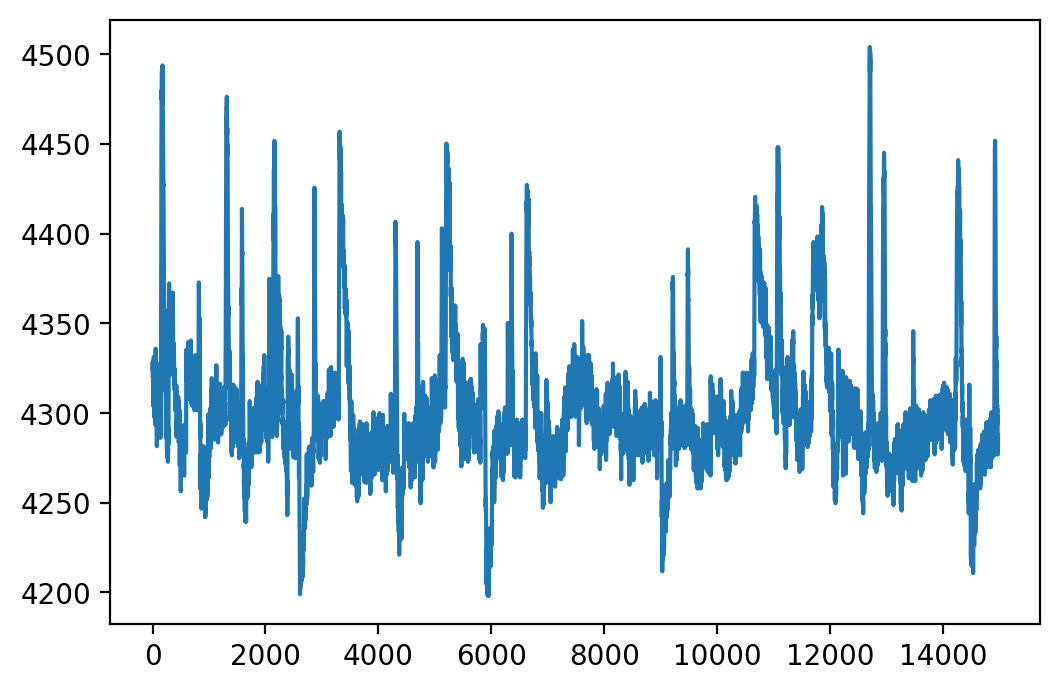

In [ ]:
sampledata = pd.read_csv("EEG_Data.csv")
sampledata = sampledata[(np.abs(stats.zscore(sampledata)) < 5).all(axis=1)]
rawfeatures = sampledata.iloc[:, 0]
print(sampledata)
plt.plot(rawfeatures)
rawfeatures = np.array(rawfeatures).reshape((rawfeatures.shape[0],1,1))
print(rawfeatures.shape)
rawlabels = np.array(sampledata['0'])
print(rawlabels)

(12781, 1, 1)


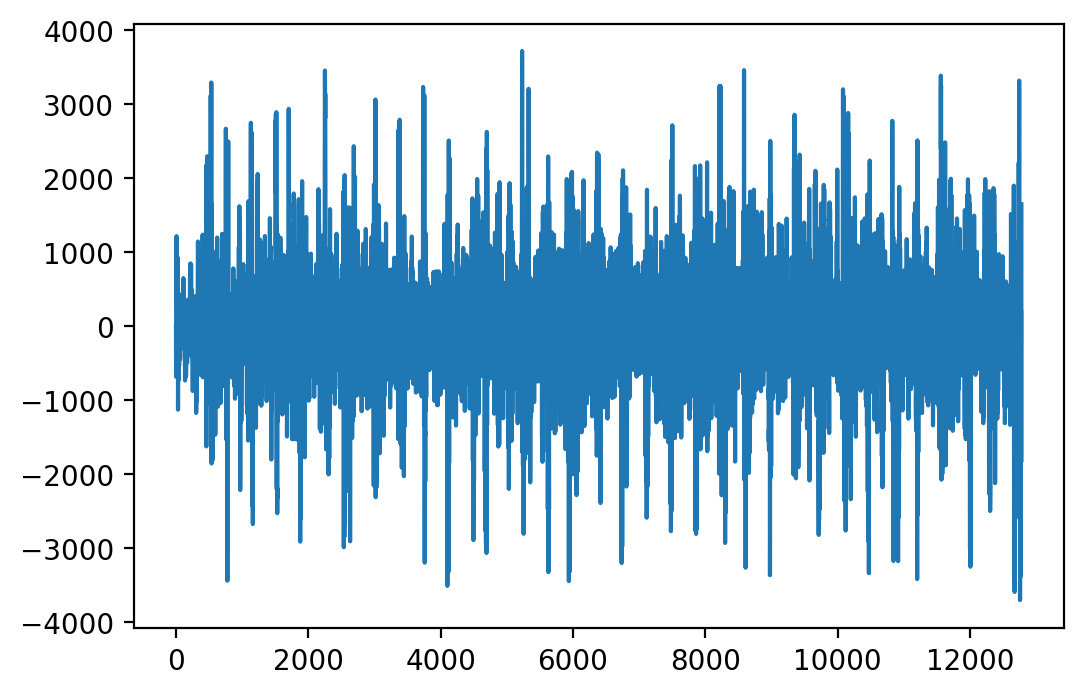

In [3]:
ourdata = pd.read_csv("preprocessed.csv")
ourdata[(np.abs(stats.zscore(ourdata)) < 5).all(axis=1)]
ourdata.drop(ourdata.tail(1).index,inplace=True)
ourfeatures = ourdata['0'] * 1000000 #convert to uv
plt.plot(ourfeatures)
ourfeatures = np.array(ourfeatures).reshape((ourfeatures.shape[0],1,1))
print(ourfeatures.shape)
ourlabels = pd.get_dummies(ourdata['blink'])[1]

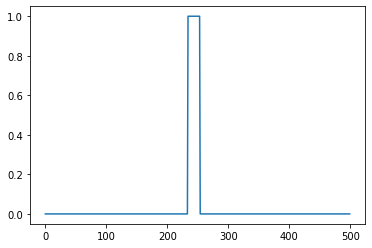

In [ ]:
plt.plot(ourlabels[0:500])

In [5]:
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM

rnn = Sequential()
rnn.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, 1)))
rnn.add(LSTM(50, activation='relu'))
rnn.add(Dense(1, activation='sigmoid'))
rnn.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
print(rnn.summary())

#RUN UP TILL HERE ON RESET

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
import os

checkpoint_path = "checkpoints/eeg.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
hist = rnn.fit(rawfeatures,rawlabels, batch_size=10, epochs = 25, verbose=2, callbacks=[cp_callback])
rnn.save_weights('./checkpoints/final')

Epoch 1/25

Epoch 1: saving model to checkpoints/eeg.ckpt
1498/1498 - 9s - loss: 0.5511 - accuracy: 0.4489 - 9s/epoch - 6ms/step
Epoch 2/25

Epoch 2: saving model to checkpoints/eeg.ckpt
1498/1498 - 5s - loss: 0.5511 - accuracy: 0.4489 - 5s/epoch - 4ms/step
Epoch 3/25

Epoch 3: saving model to checkpoints/eeg.ckpt
1498/1498 - 5s - loss: 0.5511 - accuracy: 0.4489 - 5s/epoch - 3ms/step
Epoch 4/25

Epoch 4: saving model to checkpoints/eeg.ckpt
1498/1498 - 5s - loss: 0.5511 - accuracy: 0.4489 - 5s/epoch - 3ms/step
Epoch 5/25

Epoch 5: saving model to checkpoints/eeg.ckpt
1498/1498 - 6s - loss: 0.5511 - accuracy: 0.4489 - 6s/epoch - 4ms/step
Epoch 6/25

Epoch 6: saving model to checkpoints/eeg.ckpt
1498/1498 - 4s - loss: 0.5511 - accuracy: 0.4489 - 4s/epoch - 3ms/step
Epoch 7/25

Epoch 7: saving model to checkpoints/eeg.ckpt
1498/1498 - 4s - loss: 0.5511 - accuracy: 0.4489 - 4s/epoch - 3ms/step
Epoch 8/25

Epoch 8: saving model to checkpoints/eeg.ckpt
1498/1498 - 6s - loss: 0.5511 - accurac

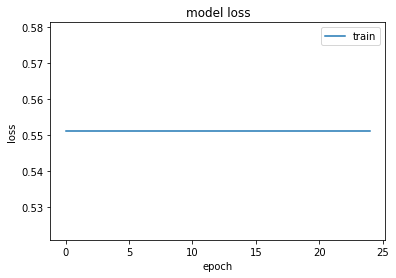

In [ ]:
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

## Train Model on Portion of our Data

In [6]:
#IF NEEDED, load model
rnn.load_weights("./checkpoints/final")

NotFoundError: ignored

In [ ]:
VAL_SPLIT = .25 # last 25% of data
val_length = int(len(ourfeatures)*VAL_SPLIT)
val_features = ourfeatures[len(ourfeatures)-val_length-1:]
val_labels = ourlabels[len(ourlabels)-val_length-1:]

hist2 = rnn.fit(val_features,val_labels,epochs=50,verbose=2)
rnn.save_weights('./checkpoints/tuned')

Epoch 1/50
100/100 - 3s - loss: 0.0508 - accuracy: 0.9462 - 3s/epoch - 28ms/step
Epoch 2/50
100/100 - 1s - loss: 0.0383 - accuracy: 0.9618 - 535ms/epoch - 5ms/step
Epoch 3/50
100/100 - 1s - loss: 0.0382 - accuracy: 0.9618 - 520ms/epoch - 5ms/step
Epoch 4/50
100/100 - 1s - loss: 0.0382 - accuracy: 0.9618 - 537ms/epoch - 5ms/step
Epoch 5/50
100/100 - 1s - loss: 0.0382 - accuracy: 0.9618 - 519ms/epoch - 5ms/step
Epoch 6/50
100/100 - 1s - loss: 0.0382 - accuracy: 0.9618 - 518ms/epoch - 5ms/step
Epoch 7/50
100/100 - 1s - loss: 0.0381 - accuracy: 0.9618 - 515ms/epoch - 5ms/step
Epoch 8/50
100/100 - 1s - loss: 0.0381 - accuracy: 0.9618 - 531ms/epoch - 5ms/step
Epoch 9/50
100/100 - 0s - loss: 0.0381 - accuracy: 0.9618 - 428ms/epoch - 4ms/step
Epoch 10/50
100/100 - 0s - loss: 0.0381 - accuracy: 0.9618 - 314ms/epoch - 3ms/step
Epoch 11/50
100/100 - 0s - loss: 0.0381 - accuracy: 0.9618 - 322ms/epoch - 3ms/step
Epoch 12/50
100/100 - 0s - loss: 0.0381 - accuracy: 0.9618 - 334ms/epoch - 3ms/step
Epo

In [ ]:
plt.plot(hist2.history['loss'])
print(hist2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

NameError: ignored

<ipython-input-123-b6f889fd8766>:5: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(['training data'], loc='bottom right')


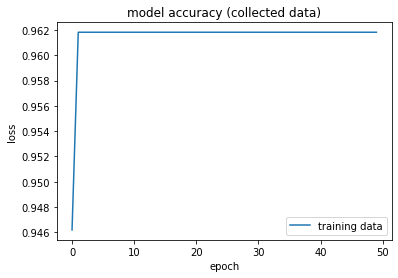

In [ ]:
plt.plot(hist2.history['accuracy'])
plt.title('model accuracy (collected data)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training data'], loc='bottom right')
plt.show()

## **Part 2: Testing Data**

In [7]:
#IF NEEDED, load tuned
rnn.load_weights("./checkpoints/tuned")

In [ ]:
test = np.array(ourfeatures).reshape((len(ourfeatures),1,1))
output = rnn.predict(test, verbose=2)
result = output > 0.04 # low threshold

400/400 - 1s - 708ms/epoch - 2ms/step


In [ ]:
print(output.argmax())

8394


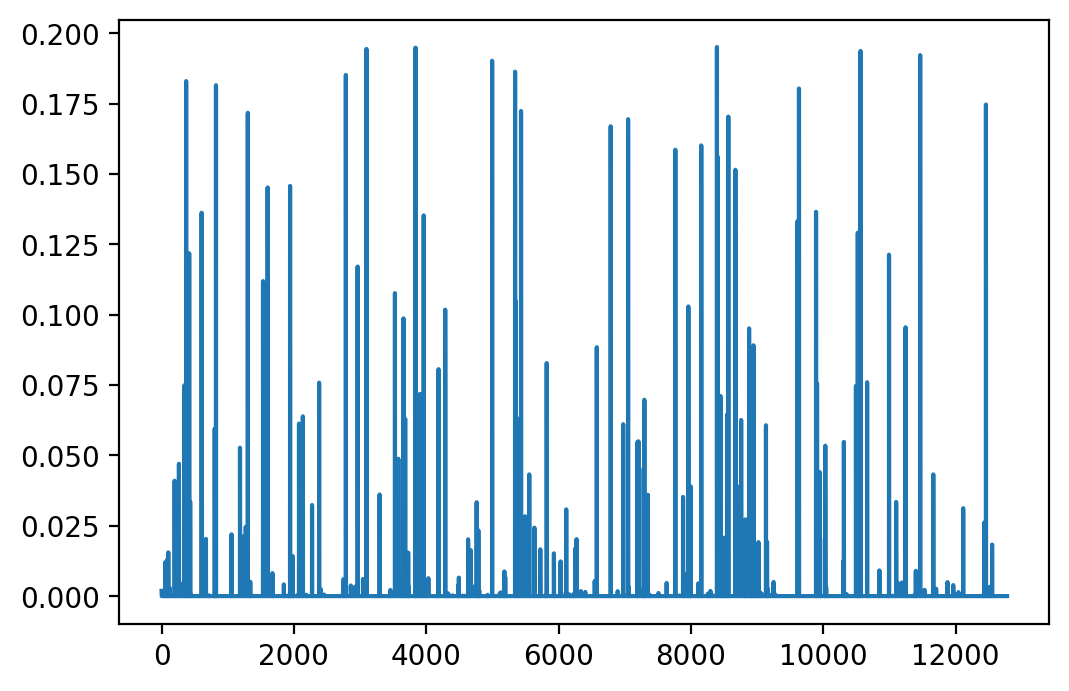

In [ ]:
BLINK_TIMES = [3.256,27.493,40.367,49.954,54.705,59.932,62.02,82.876,86.506,93.762,108.902,113.398,119.557,123.655,125.266,127.693,129.375,130.225,131.258,139.9,152.801,170.144]
plt.plot(output)

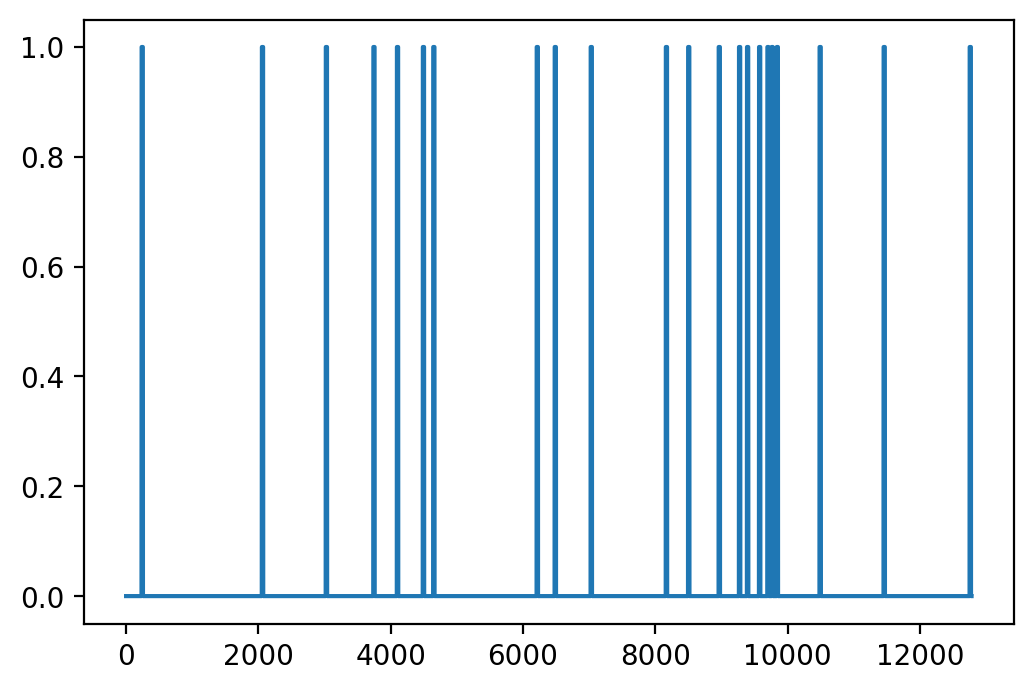

In [18]:
# Real values
BLINK_TIMES = [3.256,27.493,40.367,49.954,54.705,59.932,62.02,82.876,86.506,93.762,108.902,113.398,119.557,123.655,125.266,127.693,129.375,130.225,131.258,139.9,152.801,170.144]
real_times = ourlabels.copy()
plt.plot(real_times)

times = np.arange(0, len(ourfeatures)/75, 1/75)

In [17]:
def get_matches(HIGH_CONF_THRESHOLD, MATCH_THRESHOLD,output=output): #"confidence", seconds
  blinks = BLINK_TIMES.copy()
  high_confidence = np.array(np.where(output>HIGH_CONF_THRESHOLD))[0]
  blank = [0 for i in range(len(ourfeatures))]
  matches = blank.copy()
  num_matches = 0
  for val in high_confidence:
    blank[val] = 1
    for i, b in enumerate(blinks):
      if b < (val/75)-MATCH_THRESHOLD: continue
      elif b > (val/75)+MATCH_THRESHOLD: break
      matches[val] = output[val]*5
      num_matches += 1
      blinks[i] = -1
  return high_confidence, blank, matches, num_matches

def acc(gm, mult=100):
  h,n = gm[0], len([ma for ma in gm[2] if ma > 0])
  if len(h)==0: return 0
  return (n/len(h))*mult

/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 1.0, 'Visualizing Machine Learning performance vs. Correct Labels')

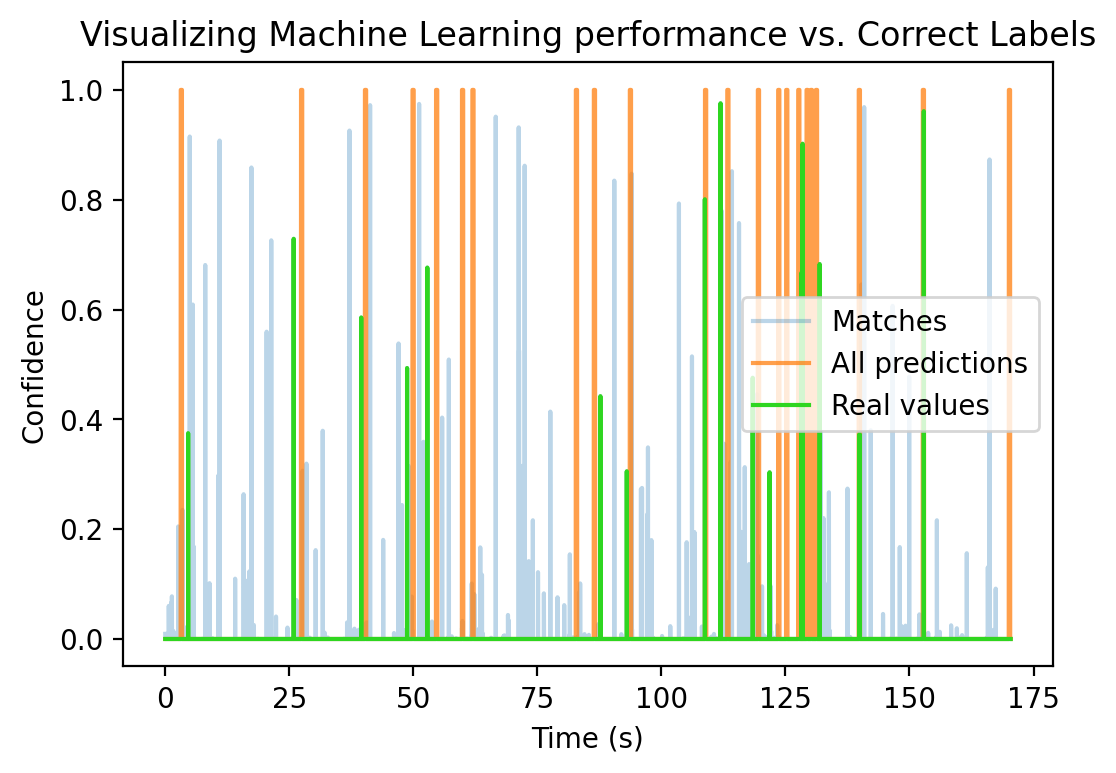

In [ ]:
fig, ax = plt.subplots()

h,b,m,n = get_matches(0.05, 2)

ax.plot(times, output*5, alpha=0.3)
ax.plot(times,real_times, alpha=0.75)
ax.plot(times, m, alpha = 1, color='#2fd620')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Confidence")
ax.legend(['Matches', 'All predictions', 'Real values'])
ax.set_title("Visualizing Machine Learning performance vs. Correct Labels")

In [ ]:
num_matches = len([ma for ma in m if ma > 0])
print(num_matches, "matches Found near", n, "blinks", len(BLINK_TIMES), "Total")

match_rate = (num_matches/len(BLINK_TIMES))*100
print('After "tuning" on 2 minutes of collected data, the % real blinks detected was ' + str(round(match_rate,2)) + "%")
print("Pct of guesses that were Matches: "+ str(round((num_matches/len(h))*100,2)) + "%")
randomness = (len(BLINK_TIMES)/(len(output)/2))*100
print("Random guessing accuracy: " + str(round(randomness, 2)) + "%")

16 matches Found near 17 blinks 22 Total
After "tuning" on 2 minutes of collected data, the % real blinks detected was 72.73%
Pct of guesses that were Matches: 23.88%
Random guessing accuracy: 0.34%


In [ ]:
# Iterate through confidence values & graph
confidences = np.arange(0.0, 0.25, 0.01)

Text(0.5, 1.0, '% Matches found with various High Confidence Thresholds')

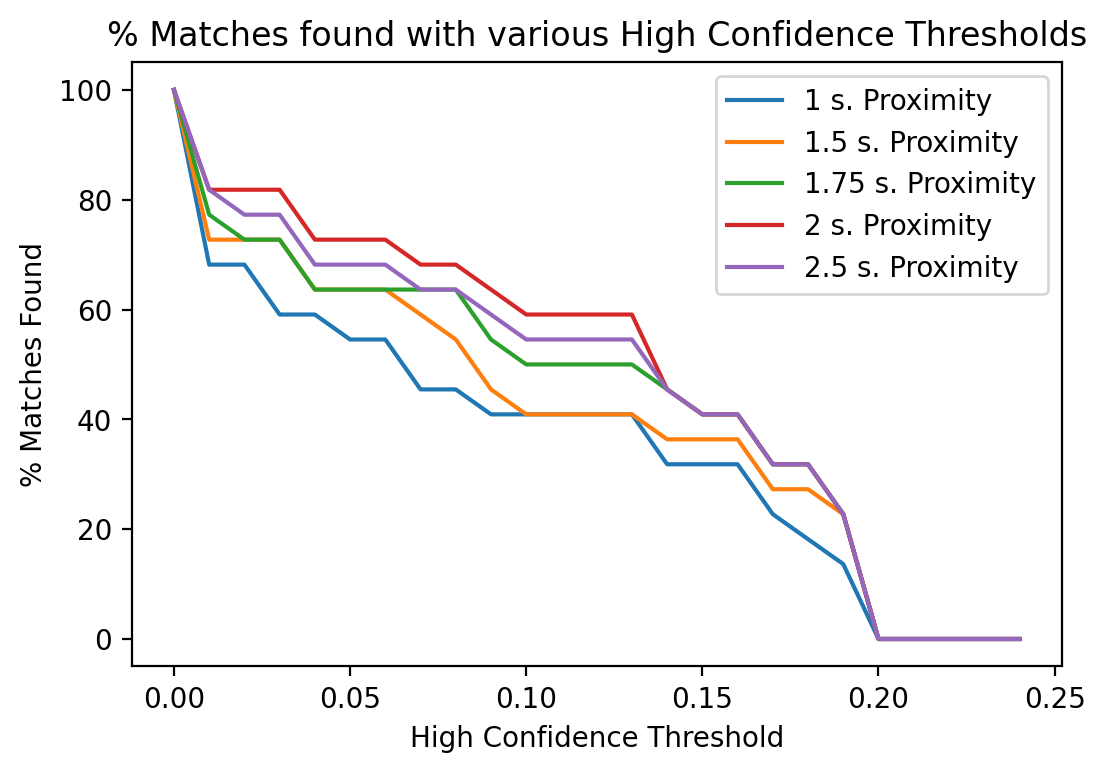

In [ ]:
# Graph number of matches by confidence/match prox

def numMatchesByProx(s, pc=100):
  num_matches = [0 for i in range(len(confidences))]
  for i, conf in enumerate(confidences):
    n = len([ma for ma in get_matches(conf, s)[2] if ma > 0])
    if n>len(BLINK_TIMES): n = len(BLINK_TIMES)
    num_matches[i] = (n/len(BLINK_TIMES))*pc
  return num_matches

PLOTTED_PROXS = [1,1.5,1.75,2, 2.5]

fig, ax = plt.subplots()
for prox in PLOTTED_PROXS:
  ax.plot(confidences, numMatchesByProx(prox))
ax.set_xlabel("High Confidence Threshold")
ax.set_ylabel("% Matches Found")
ax.legend([str(p) + " s. Proximity" for p in PLOTTED_PROXS])
ax.set_title("% Matches found with various High Confidence Thresholds")

In [ ]:
# Graph accuracy by confidence/match prox

def accuracyByProx(s, pc=100):
  accuracies = [0 for i in range(len(confidences))]
  for i, conf in enumerate(confidences):
    accuracies[i] = acc(get_matches(conf, s), pc)
  return accuracies


PLOTTED_PROXS = [1,1.5,1.75,2,2.5]

fig, ax = plt.subplots()
for prox in PLOTTED_PROXS:
  ax.plot(confidences, accuracyByProx(prox))
ax.set_xlabel("High Confidence Threshold")
ax.set_ylabel("% Accuracy")
ax.legend([str(p) + " s. Proximity" for p in PLOTTED_PROXS])
ax.set_title("% Accuracy of various High Confidence Thresholds")

Text(0.5, 1.0, 'Finding Optimal HCT using % accuracy and number of matches')

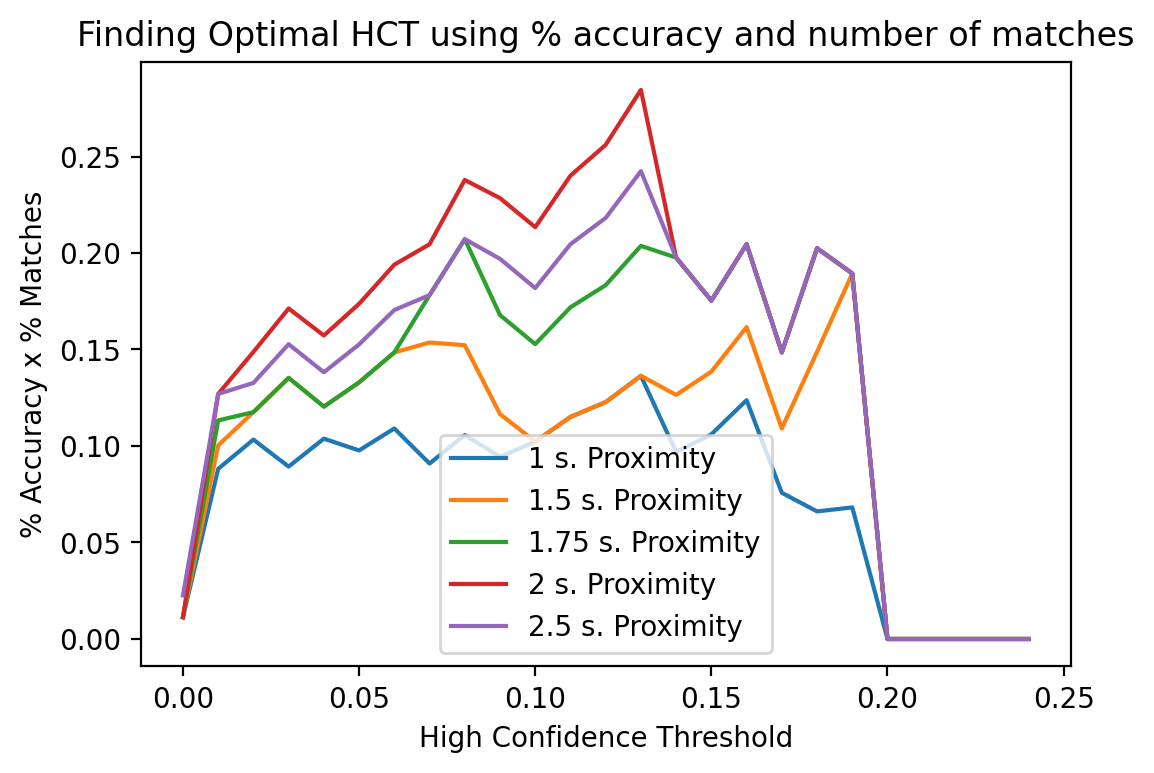

In [ ]:
def accTimesMatch(s):
  return np.array(numMatchesByProx(s, 1)) * np.array(accuracyByProx(s, 1))

PLOTTED_PROXS = [1,1.5,1.75,2,2.5]

fig, ax = plt.subplots()
for prox in PLOTTED_PROXS:
  ax.plot(confidences, accTimesMatch(prox))
ax.set_xlabel("High Confidence Threshold")
ax.set_ylabel("% Accuracy x % Matches")
ax.legend([str(p) + " s. Proximity" for p in PLOTTED_PROXS])
ax.set_title("Finding Optimal HCT using % accuracy and number of matches")

13 matches Found near 14 blinks 22 Total


/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 1.0, 'Visualizing Machine Learning performance vs. Correct Labels')

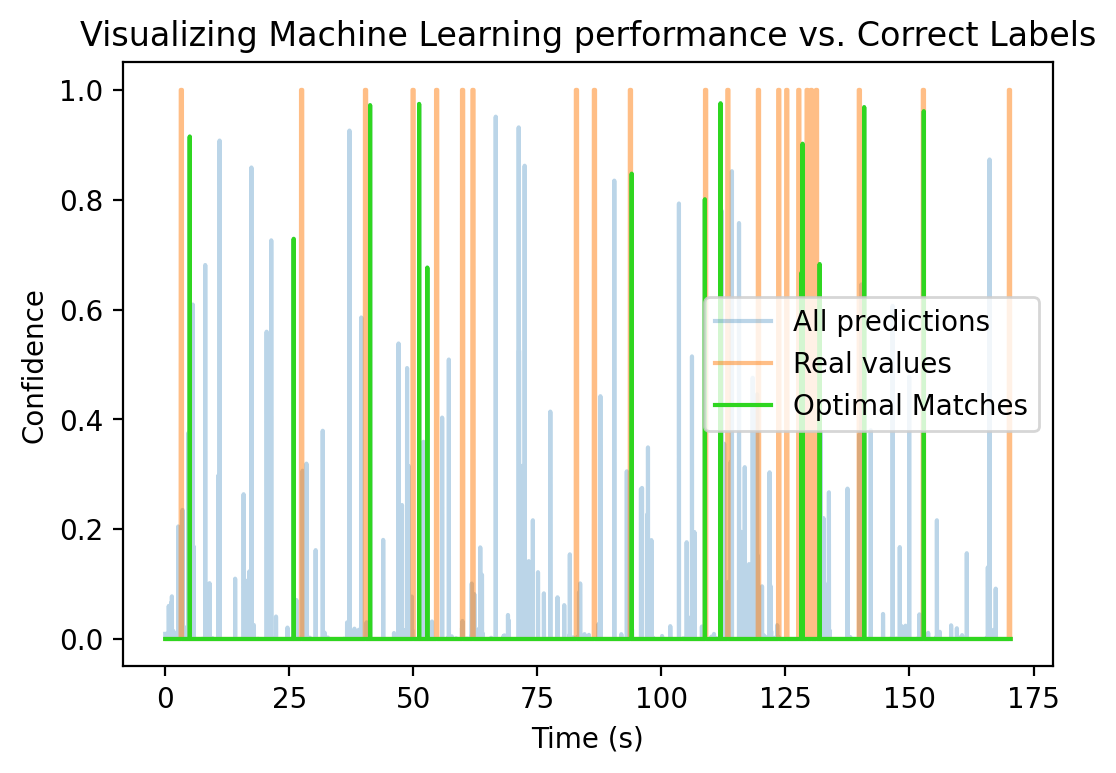

In [ ]:
OPTIMAL_MATCH_PROX = 2
OPTIMAL_HIGH_CONF = 0.13

#graph and find accuracy with optimal configurations
fig, ax = plt.subplots()

h,b,m,n = get_matches(OPTIMAL_HIGH_CONF, OPTIMAL_MATCH_PROX)
num_matches = len([ma for ma in m if ma > 0])
print(num_matches, "matches Found near", n, "blinks", len(BLINK_TIMES), "Total")
ax.plot(times, output*5, alpha=0.3)
ax.plot(times,real_times, alpha=0.5)
ax.plot(times, m, alpha = 1, color='#2fd620')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Confidence")
ax.legend(['All predictions', 'Real values', 'Optimal Matches',])
ax.set_title("Visualizing Machine Learning performance vs. Correct Labels")

### **Final Statistics**

In [ ]:
accuracy = (num_matches/len(BLINK_TIMES))
print("Percent of Real Blinks Detected:", str(round(accuracy*100,2)) + "%")
print("Detection Accuray: "+ str(round((num_matches/len(h))*100,2)) + "%")

random_acc = (len(BLINK_TIMES)/(len(output)/2))
zscore = (accuracy*100-random_acc*100)/2
print("Z-score:", str(round(zscore,2)))
probability = 1-stats.norm.cdf(zscore)
print("Probability of randomly getting", str(int(accuracy*100)) + "% accuracy is", str(round(probability*100,2)) + "%")

Percent of Real Blinks Detected: 59.09%
Detection Accuray: 18.06%
Z-score: 29.37
Probability of randomly getting 59% accuracy is 0.0%


## Part 4: Show improvement in accuracy via preprocessing

       Unnamed: 0        time      data  blink
0               0    0.000000 -0.002375    0.0
1               1    0.013333 -0.013625    0.0
2               2    0.026667 -0.004250    0.0
3               3    0.040000  0.019000    0.0
4               4    0.053333  0.011250    0.0
...           ...         ...       ...    ...
12875       12875  171.666667  0.022500    0.0
12876       12876  171.680000  0.025625    0.0
12877       12877  171.693333  0.014000    0.0
12878       12878  171.706667 -0.019250    0.0
12879       12879         NaN       NaN    NaN

[12880 rows x 4 columns]
(12879, 1, 1)


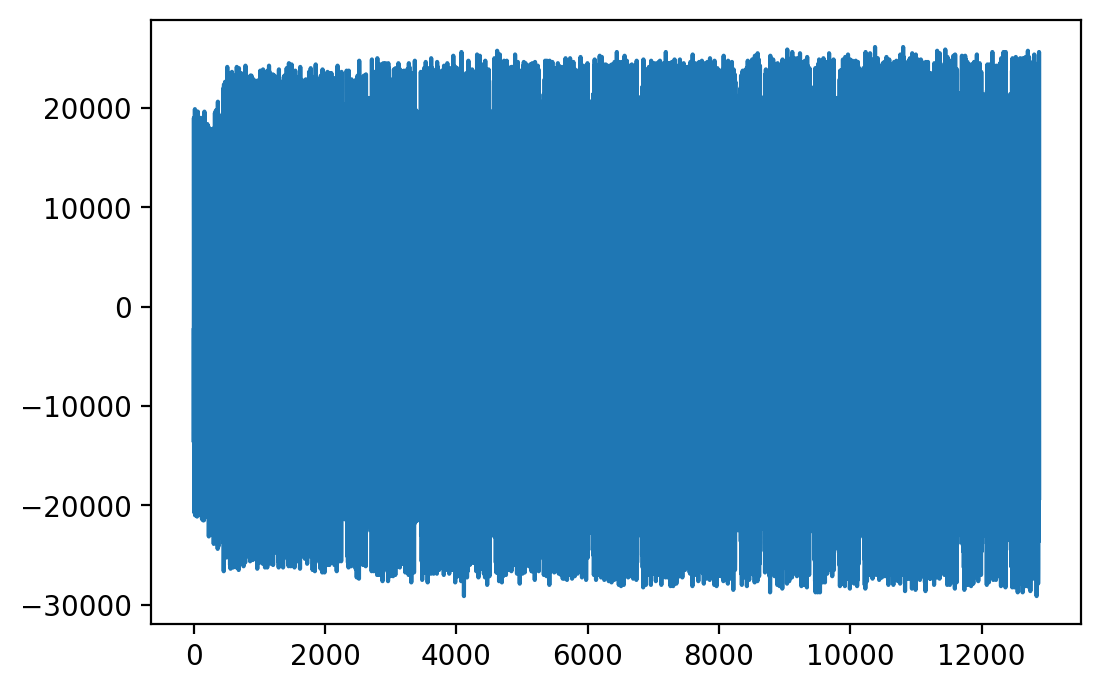

In [ ]:
unprocessed = pd.read_csv("edited.csv")
print(unprocessed)
unp = unprocessed.copy()
unp.drop(unp.tail(1).index,inplace=True)
unp = unp['data'] * 1000000 #convert to uv
plt.plot(unp)
unp = np.array(unp).reshape((unp.shape[0],1,1))
print(unp.shape)

In [ ]:
testraw = np.array(unp).reshape((len(unp),1,1))
rawout = rnn.predict(testraw, verbose=2)
rawres = rawout > 0.04 # low threshold

403/403 - 1s - 910ms/epoch - 2ms/step


0


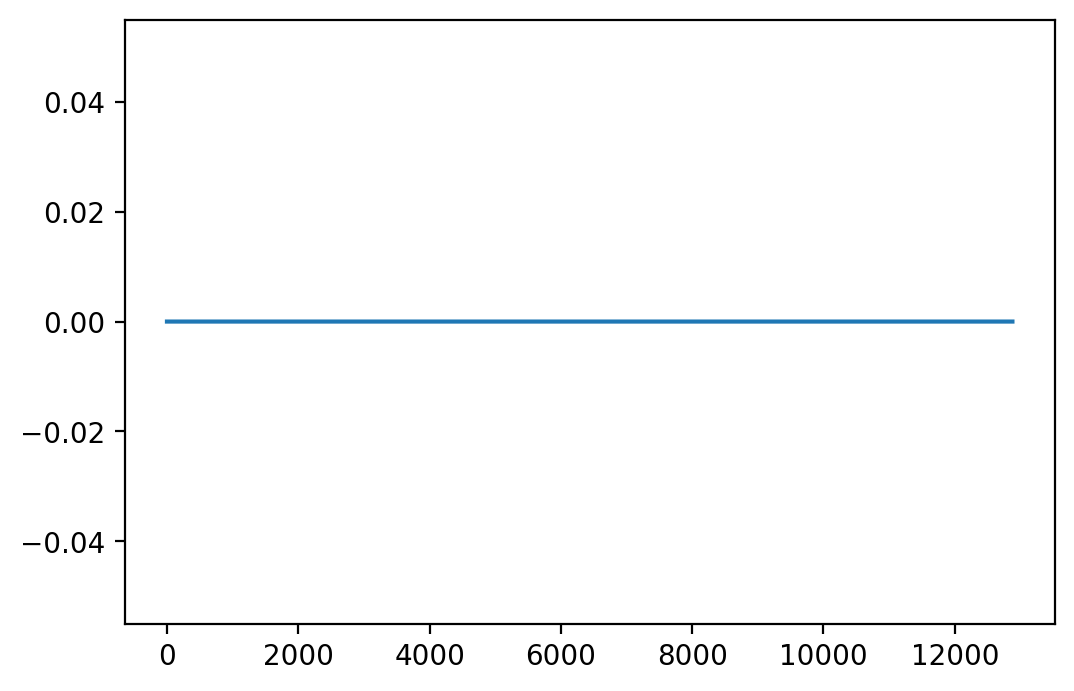

In [ ]:
print(rawres.argmax())
plt.plot(rawres)

Text(0.5, 1.0, 'Visualizing Machine Learning performance vs. Correct Labels')

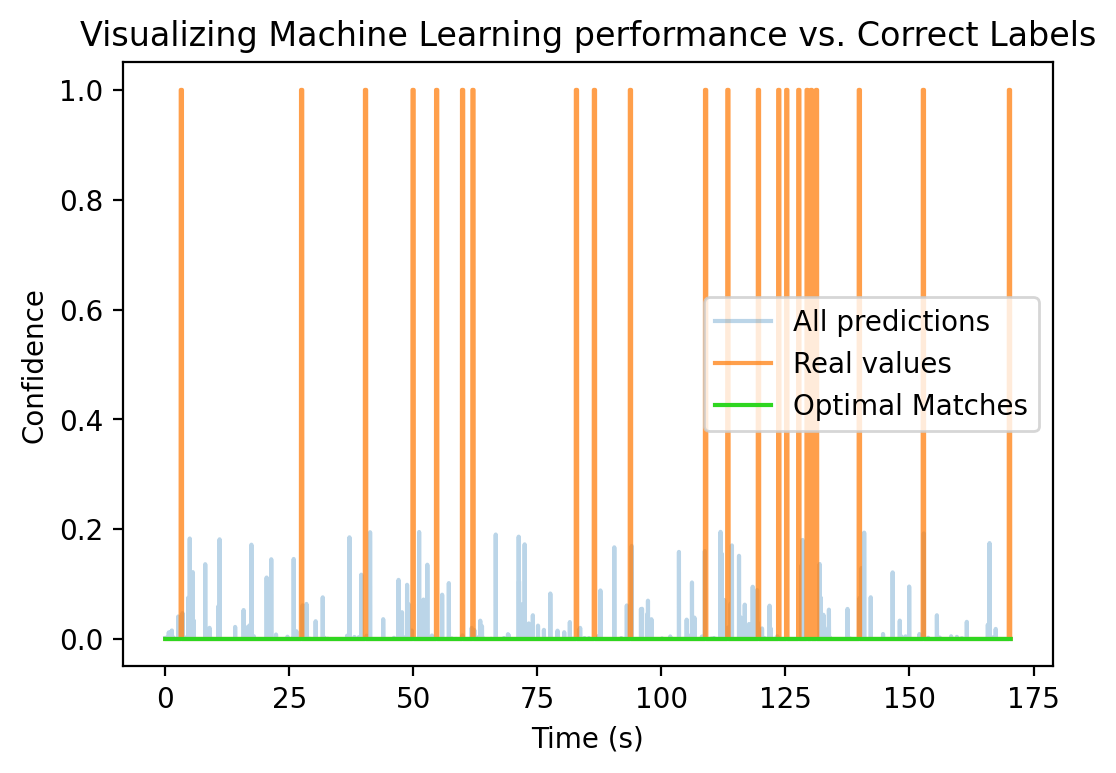

In [ ]:
fig, ax = plt.subplots()

h,b,m,n = get_matches(OPTIMAL_HIGH_CONF, OPTIMAL_MATCH_PROX,rawres)

ax.plot(times, output, alpha=0.3)
ax.plot(times,real_times, alpha=0.75)

ax.plot(times, np.array(m)/5, alpha = 1, color='#2fd620')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Confidence")
ax.legend(['All predictions', 'Real values', 'Optimal Matches'])
ax.set_title("Visualizing Machine Learning performance vs. Correct Labels")

In [ ]:
accuracy = (num_matches/len(BLINK_TIMES))
num_matches = len([ma for ma in m if ma > 0])
print("Percent of Real Blinks Detected:", str(round(accuracy*100,2)) + "%")
print("Detection Accuracy: "+ str(round((num_matches/(len(h) if len(h) > 0 else len(rawres)))*100,2)) + "%")

random_acc = (len(BLINK_TIMES)/(len(output)/2))
zscore = (accuracy*100-random_acc*100)/2
print("Z-score:", str(round(zscore,2)))
probability = 1-stats.norm.cdf(zscore)
print("Probability of randomly getting", str(int(accuracy*100)) + "% accuracy is", str(round(probability*100,2)) + "%")

Percent of Real Blinks Detected: 0.0%
Detection Accuracy: 0.0%
Z-score: -0.17
Probability of randomly getting 0% accuracy is 56.83%


## **Testing Model Performance after Epoching**

In [32]:
rnn.load_weights('./checkpoints/realtime')

In [33]:
def chunks(lst, n): # From StackOverflow
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

epoched_data = list(chunks(ourfeatures, 75))
print(len(epoched_data), "epochs")

171 epochs


In [34]:
epoch_blinks = []
for epoch in epoched_data:
  test = np.array(epoch).reshape((len(epoch),1,1))
  output = rnn.predict(test, verbose=0)
  result = output > 0.04 # low threshold
  is_match = False
  for point in result:
    if point >= 0.13: #HCT
      is_match = True
      break
  if is_match: epoch_blinks.append(1)
  else: epoch_blinks.append(0)
print(epoch_blinks)

[0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


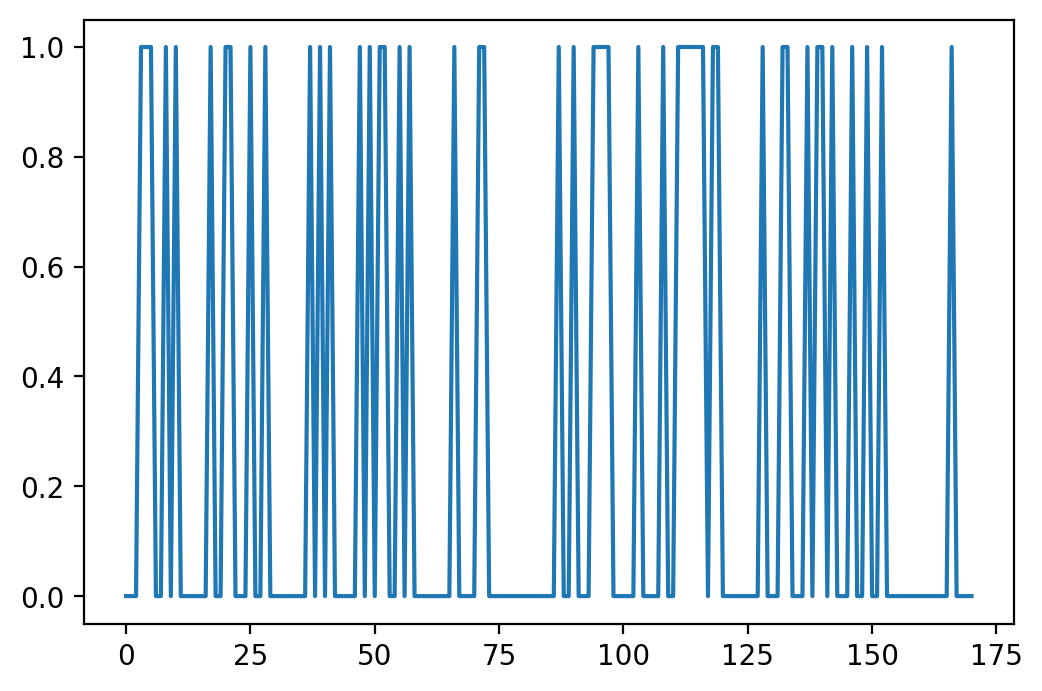

In [35]:
plt.plot(epoch_blinks)

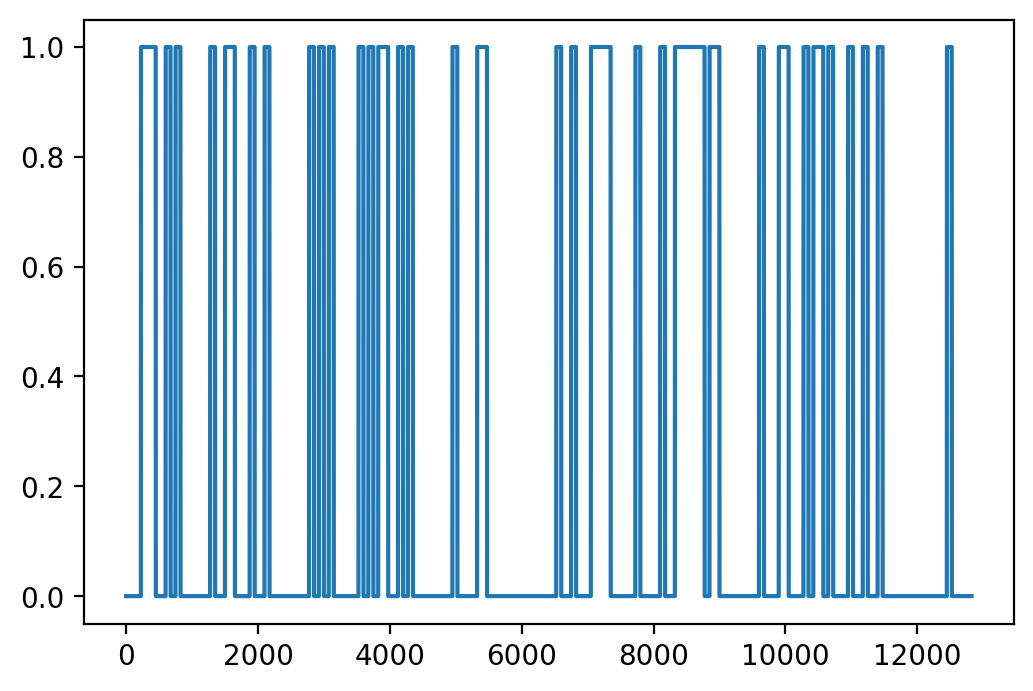

In [36]:
timeseries_epoch_blinks = []
for epoch in epoch_blinks:
  epoch_ts = [epoch for i in range(75)]
  timeseries_epoch_blinks += epoch_ts
plt.plot(timeseries_epoch_blinks)

Text(0.5, 1.0, 'Visualizing Machine Learning performance vs. Correct Labels')

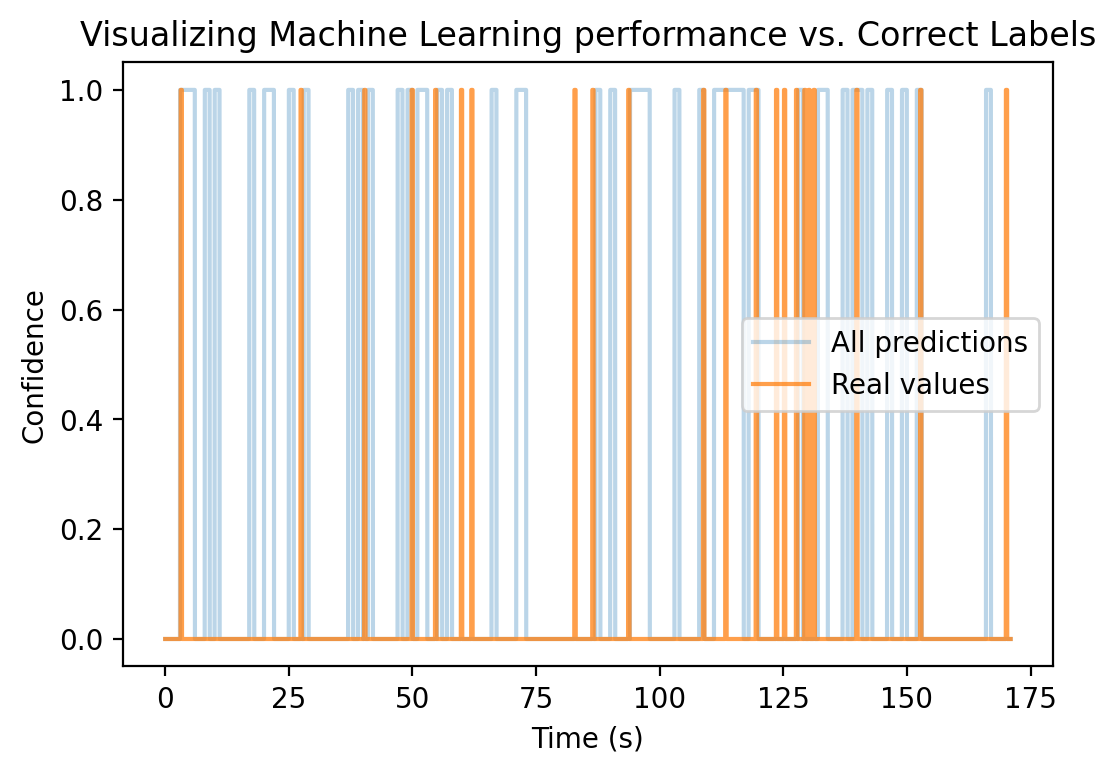

In [37]:
times = np.arange(0, len(timeseries_epoch_blinks)/75, 1/75)

fig, ax = plt.subplots()
ax.plot(times, timeseries_epoch_blinks, alpha=0.3)
ax.plot(times,list(real_times)+list([0 for i in range(44)]), alpha=0.75)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Confidence")
ax.legend(['All predictions', 'Real values', 'Matches'])
ax.set_title("Visualizing Machine Learning performance vs. Correct Labels")

## Train Tuned Model on Epoch Format

In [31]:
VAL_SPLIT = .25 # last 25% of data
val_length = int(len(ourfeatures)*VAL_SPLIT)
val_features = list(chunks(ourfeatures[len(epoched_data)-val_length-1:], 75))[:-1]
val_labels = list(chunks(ourlabels[len(ourlabels)-val_length-1:],75))[:-1]

for i, epoch in enumerate(val_features):
  hist2 = rnn.fit(epoch,val_labels[i],epochs=2,verbose=2)
rnn.save_weights('./checkpoints/realtime')

Epoch 1/2
3/3 - 0s - loss: 0.0267 - accuracy: 0.9733 - 38ms/epoch - 13ms/step
Epoch 2/2
3/3 - 0s - loss: 0.0267 - accuracy: 0.9733 - 31ms/epoch - 10ms/step
Epoch 1/2
3/3 - 0s - loss: 0.2667 - accuracy: 0.7333 - 45ms/epoch - 15ms/step
Epoch 2/2
3/3 - 0s - loss: 0.2667 - accuracy: 0.7333 - 49ms/epoch - 16ms/step
Epoch 1/2
3/3 - 0s - loss: 0.2663 - accuracy: 0.7333 - 58ms/epoch - 19ms/step
Epoch 2/2
3/3 - 0s - loss: 0.2663 - accuracy: 0.7333 - 36ms/epoch - 12ms/step
Epoch 1/2
3/3 - 0s - loss: 0.2667 - accuracy: 0.7333 - 46ms/epoch - 15ms/step
Epoch 2/2
3/3 - 0s - loss: 0.2667 - accuracy: 0.7333 - 44ms/epoch - 15ms/step
Epoch 1/2
3/3 - 0s - loss: 8.0164e-09 - accuracy: 1.0000 - 45ms/epoch - 15ms/step
Epoch 2/2
3/3 - 0s - loss: 1.0748e-08 - accuracy: 1.0000 - 40ms/epoch - 13ms/step
Epoch 1/2
3/3 - 0s - loss: 1.2672e-08 - accuracy: 1.0000 - 42ms/epoch - 14ms/step
Epoch 2/2
3/3 - 0s - loss: 1.5523e-08 - accuracy: 1.0000 - 30ms/epoch - 10ms/step
Epoch 1/2
3/3 - 0s - loss: 1.0192e-08 - accuracy